In [2]:
# Importing all the dependencies

import numpy as np
from matplotlib import pyplot as plt
import cv2
import ipdb
import scipy
import math
from itertools import combinations

In [3]:
# function to compute the centroid of the given points
def getCentroid(points):
    xSum = sum([i[0] for i in points])
    ySum = sum([i[1] for i in points])
    centroid = (xSum/len(points), ySum/len(points) )
    return centroid

In [4]:
# function to subtract all the points in the polygon to bring the centroid to the origin
def recenter(points):
    centroid = getCentroid(points)
    recentered = np.empty((len(points), len(points[0])), dtype = np.float32)
    for i, point in enumerate(points):
        recentered[i][0] = (point[0]-centroid[0])
        recentered[i][1] = (point[1]-centroid[1])
    
    return np.array([centroid]), recentered

### Problem 4.3 Recovering the original transformation

In [5]:
# function to compute the Rotation and translation between point correspondences
# by linear least squares optimization
def findRotationTranslation(pointsA, pointsB):
    #recenter all the points w.r.t their centroids to overlap both the centroids at the origin
    centroidA, recenteredA = recenter(pointsA)
    centroidB, recenteredB = recenter(pointsB)
    dim = len(pointsA[0])
    H = []
    for i in range(dim):
        recenteredRowA = np.array([recenteredA[i]])
        recenteredRowB = np.array([recenteredB[i]])
        if i == 0:
            # by LLS, H = sum[(P - P_centroid).transpose*(Q - Q_centroid)]
            H = np.matmul(recenteredRowA.T, recenteredRowB)
        H = np.add(H, np.matmul(recenteredRowA.T, recenteredRowB))
    S, U, Vt = cv2.SVDecomp(H)
    # rot = V * U.transpose
    rotMat = np.matmul(Vt.T, U.T)
    rot = math.degrees(np.arccos(rotMat[0, 0]))
    # translation = (Q_centroid - R*P_centroid)
    translationMat = np.subtract(centroidB.T, np.matmul(rotMat,centroidA.T))
    return rot, translationMat

### Feauture Matcher

In [6]:
def getMatchedPairs(Corners1, Corners2, Angles1, Angles2):
    matchedPairs = list()
    for i in range(len(Angles1)):
        for j in range(len(Angles2)):
            # if the difference in the angles is less than a threshold value, 
            #choose the pair as a good match
            if(abs(Angles2[j]-Angles1[i]) < 1):
                matchedPairs.append((Corners1[i],Corners2[j]))
    return matchedPairs

### Feauture descriptors (Angles)

In [7]:
def getAngle(b, tup):
    a, c = tup
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    #constructing the vectors
    ba = a - b
    bc = c-b
    # for getting angles between two vectors, 
    # cos_theta = dot(vecA, vecB)/(mag(A)mag(B)) 
    cosin_angl = np.dot(ba,bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angl = np.arccos(cosin_angl)
    return np.degrees(angl)

In [8]:
def getAngles(Points):

    size = len(Points)
    
    maxAngle = list()
    for i, point in enumerate(Points):
        #calculate angles from i to each of the other 2 points
        angles = list()
        pointsList = list(combinations((Points[:i]+Points[i+1:]),2))
        
        for j, pair in enumerate(pointsList):
            angles.append(getAngle(point,pair))
        
        maxAngle.append(max(angles))
    return maxAngle

In [9]:
def getDistanceSum(Points):
    size = len(Points)
    distArr = np.empty((size,size), dtype= np.float32)
    distSum = np.zeros(size, dtype = np.float32)
    for i in range(size):
        for j in range(i,size):
            if i==j:
                distArr[i,j]=0
            else:
                distArr[i, j] = np.sqrt(((Points[i][0]-Points[j][0])**2)+((Points[i][1]-Points[j][1])**2))
                distArr[j, i] = distArr[i, j]
        distSum[i] = np.sum(distArr[i])
    
    
    return distSum                                         

In [10]:
######## Problem 4 2D Transformations ##########

In [11]:
def binaryHistogram(image, points):
    hist = list()
    for i, coord in enumerate(points):
        imgWindow = image[coord[1]-2 : coord[1]+2, coord[0]-2:coord[0]+2]
        hist.append(np.sum(imgWindow))
    return hist

In [12]:
# function for performing corner detection
def detectHarris(Img):
    row, col = Img.shape
    iX = cv2.Sobel(Img,cv2.CV_64F,1,0,ksize = 3)
    iXNorm = iX - np.mean(iX)
    iY = cv2.Sobel(Img,cv2.CV_64F,0,1,ksize = 3)
    iYNorm = iY - np.mean(iY)
    iX_2 = iXNorm*iXNorm
    iY_2 = iYNorm*iYNorm
    iXY = iXNorm*iYNorm

    iX_2Norm = cv2.GaussianBlur(iX_2, (3,3), 2)
    iY_2Norm = cv2.GaussianBlur(iY_2, (3,3), 2)
    iXYNorm = cv2.GaussianBlur(iXY, (3,3), 2)
    R = np.zeros((row, col))
    maxCorner = 0
    cornerIndices = list()
    for i in range(row):
        for j in range(col):
            M = np.array([[iX_2Norm[i,j], iXYNorm[i,j]],[iXYNorm[i,j], iY_2Norm[i,j]]], dtype = np.float64)
            R[i, j] = np.linalg.det(M) - 0.04 * np.power(np.trace(M),2)
            if (R[i,j]>maxCorner):
                maxCorner = R[i, j]
    for k in range(1, row-1):
        for l in range(1, col-1):            
            if(R[k,l]> 0.3*maxCorner and R[k,l]>R[k-1,l-1] and R[k,l]> R[k-1, l+1] and R[k,l]>R[k+1, l-1]) and R[k,l]>R[k+1, l+1] and R[k,l]>R[k, l-1] and R[k,l]>R[k-1, l] and R[k,l]>R[k, l+1] and R[k,l]>=R[k+1, l] :  
                cornerIndices.append([l,k])
    return cornerIndices


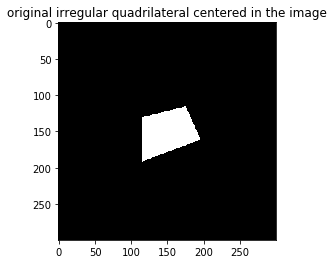

In [13]:
######## Section 4.1 ##########
img = np.zeros((300,300), np.uint8)
polyPoints = np.array([[180, 60], [120,75], [120, 135], [200, 105]], dtype = np.int32)

# this is the center around which the image will be rotated later.
centerForRot = (150,150)
Img = cv2.fillPoly(img, [polyPoints], 1)

# to make sure the polygon is in the center, translate the centroid to the center of the image 
originalCentroid = getCentroid(polyPoints)
tX = originalCentroid[0]-centerForRot[0]
tY = originalCentroid[1]-centerForRot[1]
originalImg = cv2.warpAffine(Img, np.float32([[1,0,-tX],[0,1,-tY]]), img.shape)
plt.imshow(originalImg, 'gray')
plt.title('original irregular quadrilateral centered in the image')
plt.show()



Rotation and Translation is not commutative. Hence to get a rotated quadrilateral at a different location, we must first perform translation by (30,100) and then rotation of the polygon around the center.

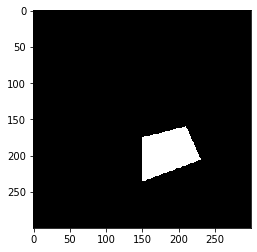

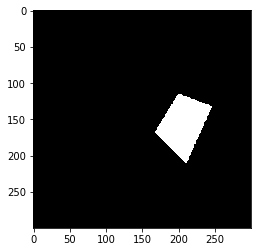

In [17]:
translationMatrix = np.float32([[1,0,30],[0,1,100]])
translatedImg = cv2.warpAffine(originalImg, translationMatrix, img.shape)
rotationMat = cv2.getRotationMatrix2D(centerForRot, 45, 1)
rotatedImg = cv2.warpAffine(translatedImg, rotationMat, originalImg.shape)
plt.imshow(translatedImg, 'gray')
plt.show()
plt.imshow(rotatedImg, 'gray')

In [18]:
cornersTransformed = detectHarris(rotatedImg)
cornersOriginal = detectHarris(originalImg)
print('original image corners ',cornersOriginal)
print('Transformed image corners ',cornersTransformed)
# pointsList = list(combinations(cornersOriginal[:1]+cornersOriginal[1+1:],2))
# print(pointsList)

original image corners  [[180, 60], [120, 75], [200, 105], [120, 135]]
Transformed image corners  [[199, 115], [245, 133], [168, 168], [210, 209]]


In [19]:
anglesOriginal = getAngles(cornersOriginal)
print(anglesOriginal)
anglesTransformed = getAngles(cornersTransformed)
print(anglesTransformed)
matches = getMatchedPairs(cornersOriginal, cornersTransformed, anglesOriginal, anglesTransformed)
#storing matches in respective pairs as list with same indexes
matchedPoints1 = [i[0] for i in matches]
matchedPoints2 = [i[1] for i in matches]
print(matchedPoints1)
print(matchedPoints2)

[99.92624550665171, 104.03624346792648, 86.59355624500529, 69.44395478041653]
[98.9529845932068, 86.64330788265305, 103.98611593958493, 70.41759158455523]
[[180, 60], [120, 75], [200, 105], [120, 135]]
[[199, 115], [168, 168], [245, 133], [210, 209]]


In [23]:
rotAngle, transMat = findRotationTranslation(matchedPoints1,matchedPoints2)

print("The rotation angle dervicd from Least Square optimization is ", rotAngle)
print("translation retained is", transMat)

shape of centroid A (1, 2)
The rotation angle dervicd from Least Square optimization is  45.51210834563913
translation retained is [[410.47440267]
 [ 56.64011386]]
